In [1]:
import numpy as np 
import scipy.stats as scistats
import scipy.io as sio 
from matplotlib import pyplot as plt 
import scipy.integrate as integrate


# Question 4




### Given data

In [4]:
dataDict = sio.loadmat("mcmc_material_linear_hardening_N20.mat")
dataDict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'time_total', 'time_avg', 'acceptance_rate', 'acceptance_count', 'parm_samples', 'stress_m', 'strain_m', 'proposal_scaling', 'stddev_of_noise'])

In [5]:
print(dataDict["stddev_of_noise"])
print(dataDict["acceptance_rate"])
print(dataDict["acceptance_count"])

[[15]]
[[0.2303     0.22574    0.27546333]]
[[1. 0. 1.]
 [0. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Standard deviation of the noise: 15.0


Text(0, 0.5, "Young's modulus $E$")

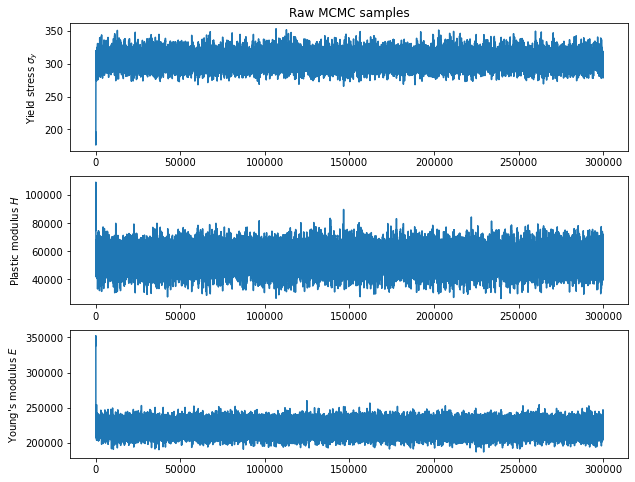

In [9]:

# These are the measurements available in the file: 
strain_m = dataDict["strain_m"].squeeze()
stress_m = dataDict["stress_m"].squeeze()

# These are the posterior samples:
parm_samples = dataDict["parm_samples"].squeeze()

# This is the standard deviation of the noise.
SIGMA = float(dataDict["stddev_of_noise"])
print("Standard deviation of the noise:", SIGMA)

def stress(e,sigma_y,H,E):
    h = lambda x: np.heaviside(x,1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

plt.figure(1,figsize=(10,8))
plt.subplot(311)
plt.title("Raw MCMC samples")
plt.plot(parm_samples[:,0])
plt.ylabel("Yield stress $\sigma_y$")
plt.subplot(312)
plt.plot(parm_samples[:,1])
plt.ylabel("Plastic modulus $H$")
plt.subplot(313)
plt.plot(parm_samples[:,2])
plt.ylabel("Young's modulus $E$")



### Part 1

The given stress and strain measurements are plotted in Figure~\ref{ADD}, along with the stress-strain model using the following parameters: $\sigma_y = 300, H = 49000, E = 210000$.

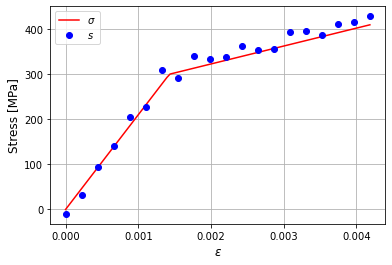

In [40]:

strain_model = np.linspace(0, strain_m[-1], 100)
sigma_y = 300
H = 49000
E = 210000

stress_model = stress(strain_model, sigma_y, H, E)

plt.figure(1)
plt.plot(strain_model, stress_model, 'r', label='$\sigma$')
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$',size=12)
plt.ylabel('Stress [MPa]',size=12)
#plt.title('Model vs Measured data')
plt.grid()
plt.savefig('Q4_measure.png',dpi=300)
plt.legend()


### Part 2


In [6]:
parameters = [300, 49000, 210000]

def log_likelihood(measured_strain, measured_stress, parm): 
    sigma_y, H, E = parm[0], parm[1], parm[2]
    Z = len(measured_strain)
    
    ll = 0
    for n in range(Z):
        mean = stress(measured_strain[n], sigma_y, H, E)
        std = SIGMA
        log_of_height = scistats.norm.logpdf(measured_stress[n], mean, std) # log of PDF
        ll += log_of_height
    
    return ll


In [7]:

log_like = log_likelihood(strain_m, stress_m, parameters)
print("Log-likelihood:", log_like)


Log-likelihood: -85.01133484296402


### Part 3


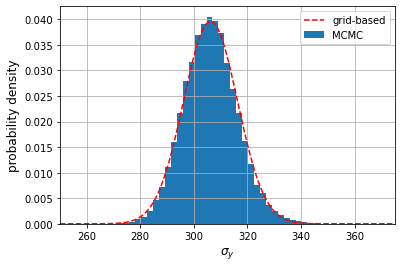

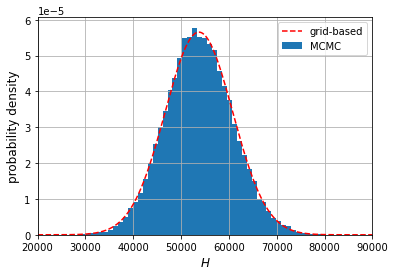

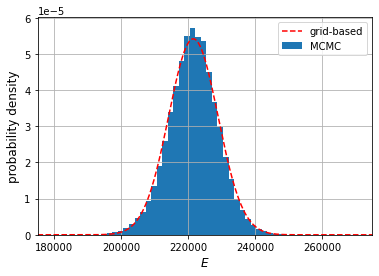

In [48]:

yield_stress_samples = parm_samples[:,0]
H_samples = parm_samples[:,1]
E_samples = parm_samples[:,2]

var_yield = np.var(yield_stress_samples)
var_H = np.var(H_samples)
var_E = np.var(E_samples)

yield_grid = np.linspace(250, 375, 10000)
yield_distrib = scistats.norm.pdf(yield_grid, loc=np.mean(yield_stress_samples), scale=np.sqrt(var_yield))

H_grid = np.linspace(20000, 90000, 10000)
H_distrib = scistats.norm.pdf(H_grid, loc=np.mean(H_samples), scale=np.sqrt(var_H))

E_grid = np.linspace(175000, 275000, 10000)
E_distrib = scistats.norm.pdf(E_grid, loc=np.mean(E_samples), scale=np.sqrt(var_E))


# YIELD STRESS
plt.figure(1)
plt.plot(yield_grid, yield_distrib, 'r--', label="grid-based")
plt.hist(yield_stress_samples,density=True,bins=80, label='MCMC')
#plt.title(r"Marginal distribution over $\sigma_y$")
plt.legend()
plt.xlabel(r"$\sigma_y$",size=12)
plt.ylabel("probability density",size=12)
plt.xlim(250, 375)
plt.grid()
plt.savefig('Q4_margin1.png',dpi=300)

# PLASTIC MODULUS
plt.figure(2)

plt.plot(H_grid, H_distrib, 'r--', label="grid-based")
plt.hist(H_samples,density=True,bins=80, label='MCMC')
#plt.title(r"Marginal distribution over $H$")
plt.legend()
plt.xlabel(r"$H$",size=12)
plt.ylabel("probability density",size=12)
plt.xlim(20000, 90000)
plt.grid()
plt.savefig('Q4_margin2.png',dpi=300)

# ELASTIC MODULUS
plt.figure(3)
plt.plot(E_grid, E_distrib, 'r--', label="grid-based")
plt.hist(E_samples,density=True,bins=100, label='MCMC')
#plt.title(r"Marginal distribution over $E$")
plt.legend()
plt.xlabel(r"$E$",size=12)
plt.ylabel("probability density",size=12)
plt.xlim(175000, 275000)
plt.grid()
plt.savefig('Q4_margin3.png',dpi=300)



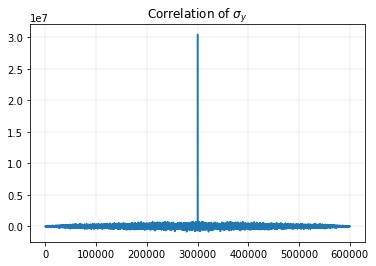

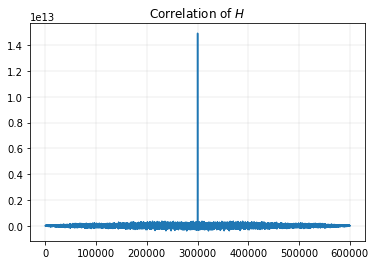

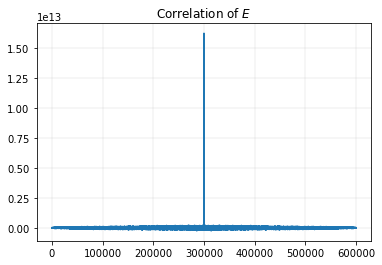

In [9]:

import scipy.signal as scisig

corr_sigma_y = scisig.correlate(yield_stress_samples-np.mean(yield_stress_samples),yield_stress_samples-np.mean(yield_stress_samples))
corr_H = scisig.correlate(H_samples-np.mean(H_samples),H_samples-np.mean(H_samples))
corr_E = scisig.correlate(E_samples-np.mean(E_samples),E_samples-np.mean(E_samples))

plt.figure(1)
plt.plot(corr_sigma_y)
plt.title(r"Correlation of $\sigma_y$")
plt.grid(linewidth=0.2)

plt.figure(2)
plt.plot(corr_H)
plt.title(r"Correlation of $H$")
plt.grid(linewidth=0.2)

plt.figure(3)
plt.plot(corr_E)
plt.title(r"Correlation of $E$")
plt.grid(linewidth=0.2)



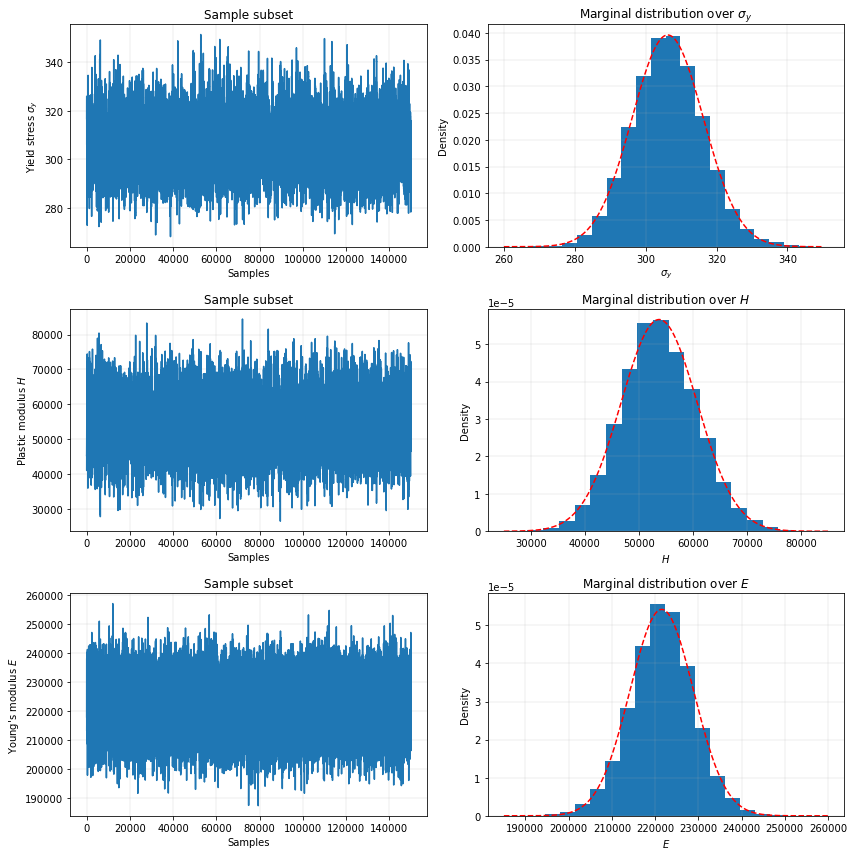

In [10]:
# Again, it would be good to superimpose the grid-based solutions. 

index = np.arange(150000,300000) # Using a subset of the samples  
# index = np.arange(150000,300000)[::10] # With thinning

# print(len(index))

yield_grid = np.linspace(260, 350, 10000)
yield_distrib = scistats.norm.pdf(yield_grid, loc=np.mean(yield_stress_samples), scale=np.sqrt(var_yield))
H_grid = np.linspace(25000, 85000, 10000)
H_distrib = scistats.norm.pdf(H_grid, loc=np.mean(H_samples), scale=np.sqrt(var_H))
E_grid = np.linspace(185000, 260000, 10000)
E_distrib = scistats.norm.pdf(E_grid, loc=np.mean(E_samples), scale=np.sqrt(var_E))



fig1, axs1 = plt.subplots(3, 2, figsize=(12,12))
axs1[0][0].plot(yield_stress_samples[index])
axs1[0][0].set_xlabel('Samples')
axs1[0][0].set_ylabel("Yield stress $\sigma_y$")
axs1[0][0].set_title('Sample subset')
axs1[0][0].grid(linewidth=0.2)
axs1[0][1].hist(yield_stress_samples[index], density=True, bins=20)
axs1[0][1].plot(yield_grid, yield_distrib, 'r--')
axs1[0][1].set_xlabel(r"$\sigma_y$")
axs1[0][1].set_ylabel("Density")
axs1[0][1].set_title(r"Marginal distribution over $\sigma_y$")
axs1[0][1].grid(linewidth=0.2)

axs1[1][0].plot(H_samples[index])
axs1[1][0].set_xlabel('Samples')
axs1[1][0].set_ylabel("Plastic modulus $H$")
axs1[1][0].set_title('Sample subset')
axs1[1][0].grid(linewidth=0.2)
axs1[1][1].hist(H_samples[index], density=True, bins=20)
axs1[1][1].plot(H_grid, H_distrib, 'r--')
axs1[1][1].set_xlabel(r"$H$")
axs1[1][1].set_ylabel("Density")
axs1[1][1].set_title(r"Marginal distribution over $H$")
axs1[1][1].grid(linewidth=0.2)

axs1[2][0].plot(E_samples[index])
axs1[2][0].set_xlabel('Samples')
axs1[2][0].set_ylabel("Young's modulus $E$")
axs1[2][0].set_title('Sample subset')
axs1[2][0].grid(linewidth=0.2)
axs1[2][1].hist(E_samples[index], density=True, bins=20)
axs1[2][1].plot(E_grid, E_distrib, 'r--')
axs1[2][1].set_xlabel(r"$E$")
axs1[2][1].set_ylabel("Density")
axs1[2][1].set_title(r"Marginal distribution over $E$")
axs1[2][1].grid(linewidth=0.2)

fig1.tight_layout()
# plt.savefig('')


Text(0, 0.5, 'Density')

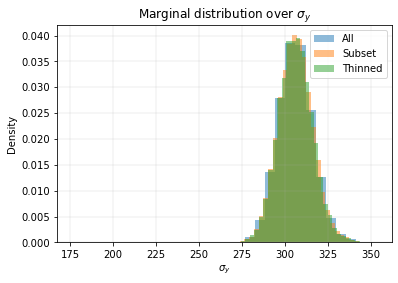

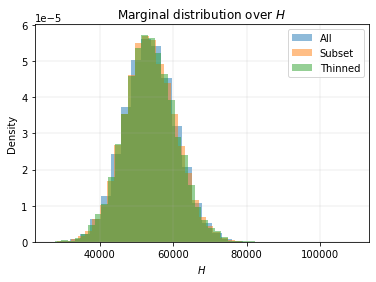

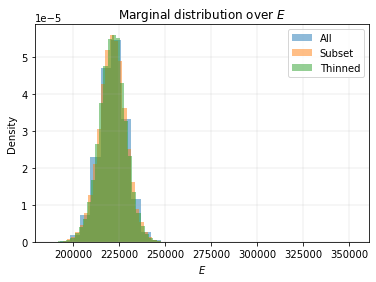

In [11]:
index = np.arange(150000,300000) # Using a subset of the samples
index2 = np.arange(150000,300000)[::10] # With thinning

# YIELD STRESS
plt.figure(1)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(yield_stress_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(yield_stress_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(yield_stress_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $\sigma_y$")
plt.legend()
plt.xlabel(r"$\sigma_y$")
plt.ylabel("Density")

# PLASTIC MODULUS
plt.figure(2)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(H_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(H_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(H_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $H$")
plt.legend()
plt.xlabel(r"$H$")
plt.ylabel("Density")

# ELASTIC MODULUS
plt.figure(3)
plt.grid(linewidth=0.2)
# maybe add grid-based solution
plt.hist(E_samples,density=True,bins=30, alpha=0.5, label='All')
plt.hist(E_samples[index],density=True,bins=30, alpha=0.5, label='Subset')
plt.hist(E_samples[index2],density=True,bins=30, alpha=0.5, label='Thinned')
plt.title(r"Marginal distribution over $E$")
plt.legend()
plt.xlabel(r"$E$")
plt.ylabel("Density")



### Part 4



In [12]:

# ESTIMATES:
print("Expected value estimate of yield stress:   ", np.mean(yield_stress_samples), np.mean(yield_stress_samples[index]),
     np.mean(yield_stress_samples[index2]))

print("Expected value estimate of plastic modulus:", np.mean(H_samples), np.mean(H_samples[index]),
     np.mean(H_samples[index2]))

print("Expected value estimate of Young's modulus:", np.mean(E_samples), np.mean(E_samples[index]),
     np.mean(E_samples[index2]))





Expected value estimate of yield stress:    306.214692641026 306.3307257624954 306.3282521725974
Expected value estimate of plastic modulus: 53728.257905879545 53681.961482316474 53696.84950198777
Expected value estimate of Young's modulus: 221514.7318665411 221451.73031061943 221518.58392888092


### Part 5



In [39]:
X = dataDict["parm_samples"].squeeze()
Xpost = np.mean(X,axis=0)

COV = np.zeros([3,3])

N = len(X)
for j in range(3):
    for k in range(3):
        COV[j,k] = (1/(N-1))*np.sum((X[j]-Xpost[j])*(X[k]-Xpost[k]).T)
        
print(COV)

[[398773.75832869 325353.75173493 111096.57328557]
 [325353.75173493 280472.98728275 153266.57313673]
 [111096.57328557 153266.57313673 292051.62361052]]


Covariance matrix:
[[ 1.01558548e+02 -5.73853064e+04 -1.87374486e+04]
 [-5.73853064e+04  4.97612283e+07 -2.62052073e+06]
 [-1.87374486e+04 -2.62052073e+06  5.42008327e+07]]


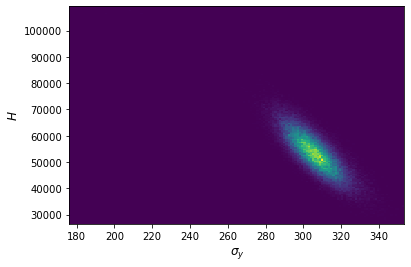

In [61]:
covariance = np.cov(parm_samples, rowvar=False)
print("Covariance matrix:")
print(covariance)


plt.figure(1)
plt.hist2d(yield_stress_samples, H_samples,150)
plt.xlabel('$\sigma_y$',size=12)
plt.ylabel('$H$',size=12)
#plt.title('Plastic moduls vs yield strength')
plt.savefig('Q4_cov.png',dpi=300)

In [18]:
np.cov?

### Part 6


In [14]:

sigma_y_5 = np.percentile(yield_stress_samples,5)
sigma_y_95 = np.percentile(yield_stress_samples,95)

H_5 = np.percentile(H_samples,5)
H_95 = np.percentile(H_samples,95)

E_5 = np.percentile(E_samples,5)
E_95 = np.percentile(E_samples,95)

print("Yield strength")
print("Mean =", np.mean(yield_stress_samples))
print(sigma_y_5, sigma_y_95)
print("")
print("Plastic modulus")
print("Mean =", np.mean(H_samples))
print(H_5, H_95)
print("")
print("Young's modulus")
print("Mean =", np.mean(E_samples))
print(E_5, E_95)
print("")


Yield strength
Mean = 306.214692641026
290.31511952855385 322.9499197153924

Plastic modulus
Mean = 53728.257905879545
42348.7994019187 65407.40517375437

Young's modulus
Mean = 221514.7318665411
209301.89881809443 233320.11302684594



42348.7994019187 209301.89881809443 290.31511952855385


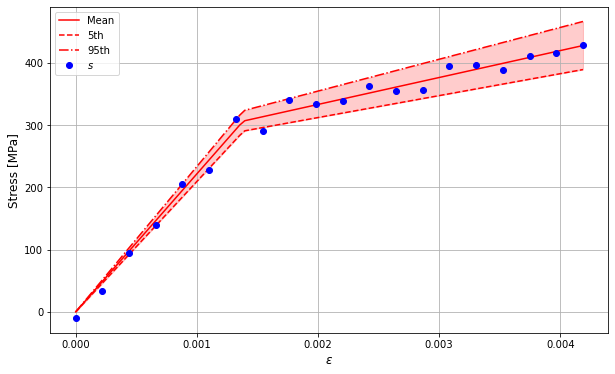

In [62]:
strain_model = np.linspace(0, strain_m[-1], 100)

# Mean
index = np.arange(0,300000) # Using a subset of the samples
sigma_y = np.mean(yield_stress_samples[index])
H = np.mean(H_samples[index])
E = np.mean(E_samples[index])
model_mean = stress(strain_model, sigma_y, H, E)

#percentiles 
sigma_y_5 = np.percentile(yield_stress_samples,5)
sigma_y_95 = np.percentile(yield_stress_samples,95)

H_5 = np.percentile(H_samples,5)
H_95 = np.percentile(H_samples,95)

E_5 = np.percentile(E_samples,5)
E_95 = np.percentile(E_samples,95)

# 5th
model_5th = stress(strain_model, sigma_y_5, H_5, E_5)

# 95th
model_95th = stress(strain_model, sigma_y_95, H_95, E_95)

plt.figure(1, (10, 6))
# plt.plot(strain_model, stress_model, 'r', label='$\sigma$')
plt.plot(strain_model, model_mean, 'r', label='Mean')
plt.plot(strain_model, model_5th, 'r--', label='5th')
plt.plot(strain_model, model_95th, 'r-.', label='95th')
plt.fill_between(strain_model, model_5th, model_95th, color="r", alpha = 0.2)  
plt.plot(strain_m, stress_m, 'bo', label='$s$')
plt.xlabel('$\epsilon$',size=12)
plt.ylabel('Stress [MPa]',size=12)
#plt.title('Model vs Measured data')
plt.grid()
plt.legend()
plt.savefig('Q4_summary.png',dpi=300)


print(H_5,E_5,sigma_y_5)

#### Does not seem correct...


### Part 7


In [55]:
def I(x,a):
    if x<=a:
        return 0
    elif x>a:
        return 1

yield_stress = yield_stress_samples[::50]
sum_theta = 0

x_ac = yield_stress

for i in range(len(x_ac)):
    sum_theta += I(x_ac[i],300)
    
P_2 = 1/len(x_ac)*sum_theta

print(P_2)

0.7333333333333333


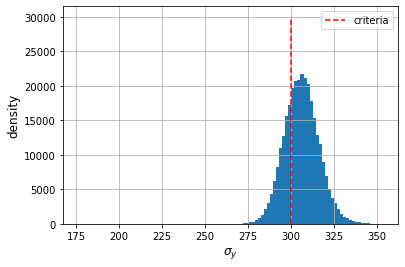

<IPython.core.display.Latex object>

In [74]:
from IPython.display import display, Latex

yield_stress = yield_stress_samples[::50]
theta = np.linspace(300,350,len(yield_stress))

plt.hist(yield_stress_samples,bins=100)
plt.plot([300,300],[0,30000],'r--',label='criteria')
plt.legend()
plt.grid()
plt.xlabel(r"$\sigma_y$",size=12)
plt.ylabel('density',size=12)
plt.savefig('Q4_MC1.png',dpi=300)
plt.show()

pdf1,_,_ = plt.hist(yield_stress,bins=theta,density=False) 
plt.close()

proba = np.sum(pdf1)/len(pdf1)
            
display(Latex(r'Using MC Integration $P (\sigma_y > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})$ = '+str(proba)))

### Part 8


In [54]:
def I(x,a):
    if x<=a:
        return 0
    elif x>a:
        return 1

def stress(e,sigma_y,H,E):
    h = lambda x: np.heaviside(x,1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

sigma = stress(0.002,yield_stress_samples, H_samples, E_samples) 
sum_theta = 0

x_ac = sigma

for i in range(len(x_ac)):
    sum_theta += I(x_ac[i],300)
    
P_2 = 1/len(x_ac)*sum_theta

print(P_2)

0.9999033333333334


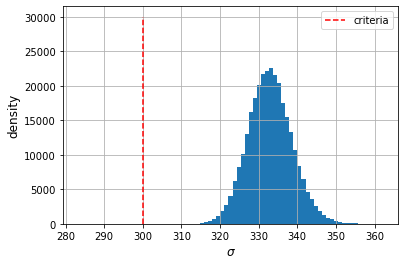

<IPython.core.display.Latex object>

In [77]:
def stress(e,sigma_y,H,E):
    h = lambda x: np.heaviside(x,1)
    sigma = E * e * (1 - h(e - sigma_y/E)) + (sigma_y + H * E/(H + E)*(e - sigma_y/E))*h(e - sigma_y/E)
    return sigma

sigma = stress(0.002,yield_stress_samples, H_samples, E_samples) 

plt.hist(sigma,bins=75)
plt.plot([300,300],[0,30000],'r--',label='criteria')
plt.legend()
plt.grid()
plt.xlabel(r"$\sigma$",size=12)
plt.ylabel('density',size=12)
plt.savefig('Q4_MC2.png',dpi=300)
plt.show()

pdf1,_,_ = plt.hist(sigma[::50],bins=len(sigma[::50]),density=False) 
plt.close()

proba = np.sum(pdf1)/len(pdf1)
            
display(Latex(r'Using MC Integration $P (\sigma > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})$ = '+str(proba)))

### Part 9



In [53]:
def I(x,a):
    if x<=a:
        return 0
    elif x>a:
        return 1

model_mean = stress(0.002, sigma_y, H, E)
s_model = scistats.norm.rvs(loc=model_mean,scale=15,size=10000)
sum_theta = 0

x_ac = s_model

for i in range(len(x_ac)):
    sum_theta += I(x_ac[i],300)
    
P_2 = 1/len(x_ac)*sum_theta

print(P_2)

0.9393


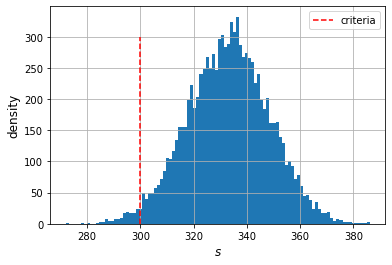

<IPython.core.display.Latex object>

In [72]:
model_mean = stress(0.002, sigma_y, H, E)

s_model = scistats.norm.rvs(loc=model_mean,scale=15,size=10000)
plt.hist(s_model,bins=100)
plt.plot([300,300],[0,300],'r--',label='criteria')
plt.legend()
plt.grid()
plt.xlabel(r"$s$",size=12)
plt.ylabel('density',size=12)
plt.savefig('Q4_MC3.png',dpi=300)
plt.show()

theta = np.linspace(300,500,len(s_model))

pdf1,_,_ = plt.hist(s_model,theta,density=False) 
plt.close()

proba = np.sum(pdf1)/len(pdf1)
            
display(Latex(r'Using MC Integration $P (s > 300 \mid \epsilon = 0.002, \mathbf{\epsilon}, \mathbf{\sigma})$ = '+str(proba)))